I really want to have a look at the Orsi, Whitworth and Nowlan (1995) definition for the southern boundary of the ACC based on the southernmost occurence of Upper Circumpolar Deep Water watermass chatarcteristics. 

The definition I want to look at the model representation of is:

**UCDW is defined where O$_2 < 4.5$ mL/L in the potential density region $27.35<\sigma_0<27.75$**

(note that model output has O$_2$ in mol/m3, need to convert threshold concentration to these units)

Since I need oxygen, will only consider the BLING p25 run here.


In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
import sys
sys.path.append('/home/Ruth.Moorman/')
import nclcmaps
import cv2
from colorspace.colorlib import HCL
from colorspace import diverging_hcl, sequential_hcl
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('axes', labelsize=15)

In [2]:
import sys
sys.path.append('/home/Ruth.Moorman/Southern_ACC_boundary_dynamics')
### import required python functions
from om4_tools import *

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import subprocess as sp
portdash = 30552
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o',memory="24GB", walltime="01:00:00",dashboard_address=f':{portdash}')
cluster.scale(2)
client = Client(cluster)
print(client)
print('http://localhost:'+str(portdash)+'/status')

<Client: 'tcp://140.208.147.176:38145' processes=0 threads=0, memory=0 B>
http://localhost:30552/status


cluster.close()
client.close()

In [4]:
def get_iaf_variable(exp_dir, cycle, nc_file, variable, chunks, lat_north = -29, year = False):
    if year == False:
        nc = xr.open_mfdataset(exp_dir+'/cycle'+str(cycle)+'/'+nc_file+'/*.'+nc_file+'.nc', chunks = chunks)
    else:
        nc = xr.open_mfdataset(exp_dir+'/cycle'+str(cycle)+'/'+nc_file+'/'+str(year)+'0101.'+nc_file+'.nc')
    v = nc[variable]
    v = v.sel(yh = slice(-90, lat_north))
    return v

### Southern ACC boundary (O2 in UCDW layer = 0.2 mol/m3)

In [5]:
## start with time mean oxygen fields for the final cycle
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r'
O2 = get_iaf_variable(expdir, 3, 'ocean_bling_cmip6_omip_tracers_year_z', 'o2', chunks = {'xh':500, 'yh':200, 'z_l':10})
## need sea water potential temperature and salinity to compute sigma fields
theta = get_iaf_variable(expdir, 3, 'ocean_annual_z', 'thetao', chunks = {'xh':500, 'yh':200, 'z_l':10})
salt = get_iaf_variable(expdir, 3, 'ocean_annual_z', 'so', chunks = {'xh':500, 'yh':200, 'z_l':10})

In [6]:
static = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
lat_north = -29
bathy = static.deptho.sel(yh = slice(-90,lat_north))
land_mask = static.wet.sel(yh = slice(-90,lat_north))
geolon = static.geolon.sel(yh = slice(-90,lat_north))
geolat = static.geolat.sel(yh = slice(-90,lat_north))

In [7]:
UCDW_O2 = 4.5*44.66/1e3 # UCDW between density thresholds is more deosygenated than this

In [8]:
UCDW_O2

0.20096999999999998

In [9]:
## time mean of O2, theta and salt
O2_mean = O2.mean(dim = 'time').load()
theta_mean = theta.mean(dim = 'time').load()
salt_mean = salt.mean(dim = 'time').load()

In [10]:
def sigma(S,theta):
    """
    potential density function from the MOM6 cookbook (https://mom6-analysiscookbook.readthedocs.io/en/latest/05_Buoyancy_Geostrophic_shear.html)
    """

    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464

    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals

    p = 100000.
    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S

    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))

    return pot_dens

In [11]:
sigma_mean = xr.apply_ufunc(sigma, salt_mean, theta_mean,dask='parallelized',output_dtypes=[salt_mean.dtype]).load()-1000

In [12]:
def so_basics(ax, land_mask=land_mask, geolon=geolon, geolat=geolat,lat_north = -29, grid = False):
    land_maskp = land_mask.sel(yh = slice(-90,lat_north))
    geolonp = geolon.sel(yh = slice(-90,lat_north))
    geolatp = geolat.sel(yh = slice(-90,lat_north))
    
    ax.contour(geolonp, geolatp,land_maskp,[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [13]:
sigma_UCDW_mask = sigma_mean.where(sigma_mean<27.75).where(sigma_mean>27.35)*0+1
UCDW_min_O2 = (O2_mean * sigma_UCDW_mask).min(dim = 'z_l').load()

In [16]:
upwell = UCDW_min_O2.fillna(0)
upwell = upwell.where(upwell==0)*0+1

In [18]:
sigma_mean

<xarray.DataArray (z_l: 35, yh: 382, xh: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [24.869751, 24.876953, 24.884521, ..., 24.845703, 24.853882,
         24.861816],
        [24.82434 , 24.831665, 24.838745, ..., 24.799805, 24.807861,
         24.816162],
        [24.778198, 24.785645, 24.79248 , ..., 24.753174, 24.761475,
         24.769531]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [24.881592, 24.888794, 24.896362, ..., 24.85791 , 24.86621 ,
         24.873657],
        [24.836304, 24.84314 , 24.850586, ..., 24.812134, 24.820068,
         24.828491],
        [24.790161, 24.797485, 24.804321, ..., 24.765137, 24.773682,
         24.781372]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [24.949951, 24.957153, 24.964966, ..., 24.927246, 24.934692,
         24.941284],
        [24.905396, 24.911743, 24.919922, ..., 24.883423, 24.890503,
         24.898193],
        [24.859985, 24.867676, 24.875366, ..., 24.83789 , 24.844849,
         24.851562]],

       ...,

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... -29.59 -29.37 -29.15
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

In [26]:
upwell_sigma = (upwell * sigma_mean)
# upwell_sigma = upwell_sigma.where(upwell_sigma>27.75)
upwell_sigma.min(dim = 'z_l').max()

<xarray.DataArray ()>
array(29.178467, dtype=float32)

In [27]:
contour = (UCDW_min_O2.where(UCDW_min_O2<UCDW_O2)*0+1).fillna(0)

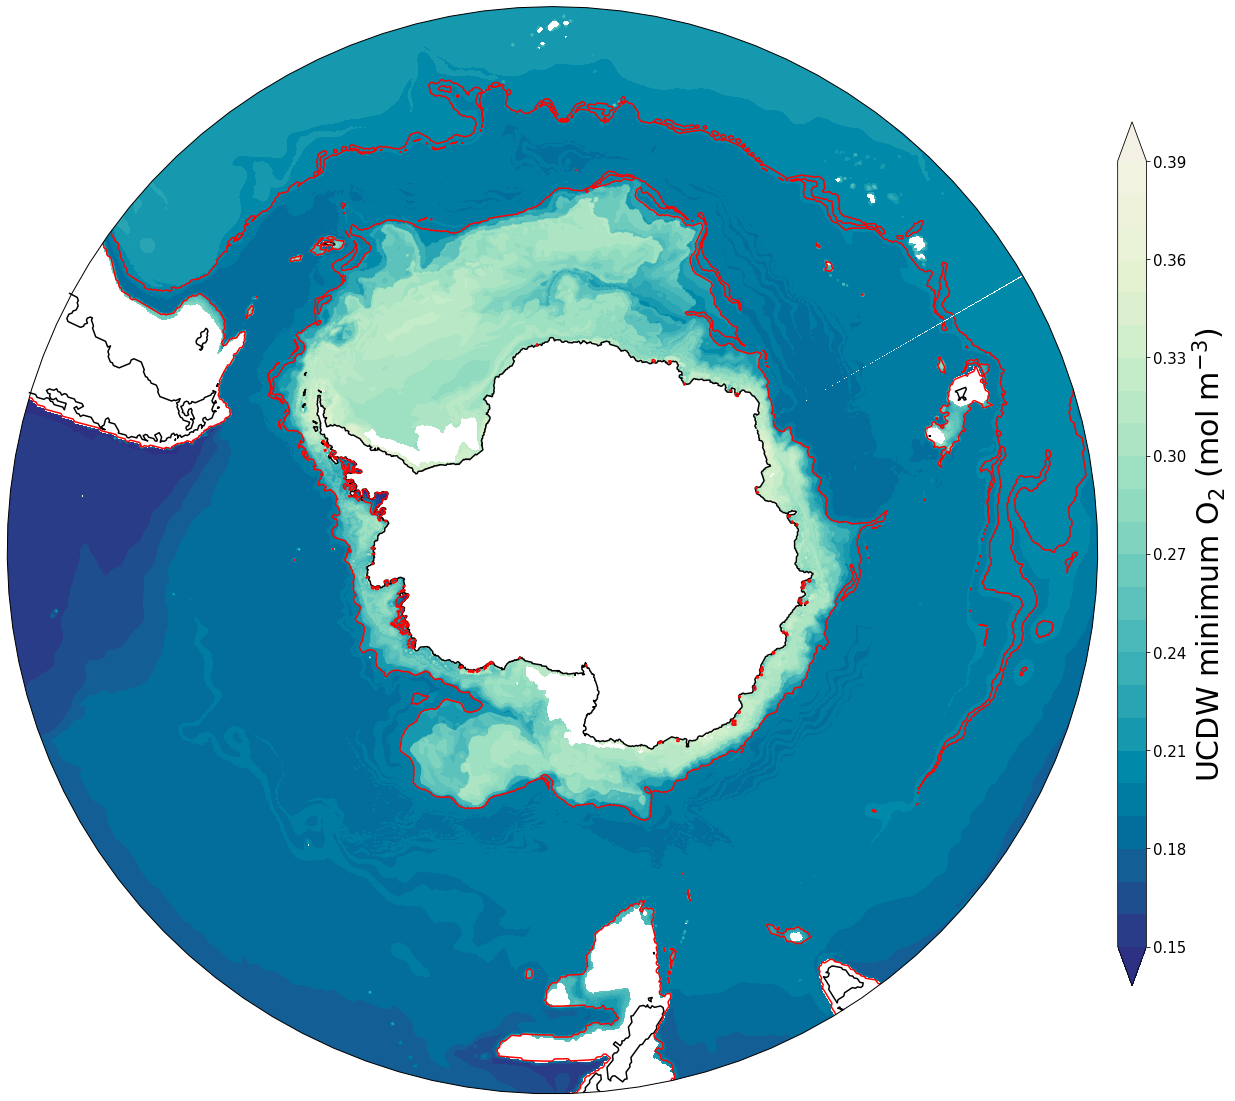

In [28]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -40
so_basics(ax,land_mask,geolon,geolat,lat_north)
hcl = sequential_hcl("Blue-Yellow")
cmap = hcl.cmap(100)
lvls = np.arange(0.15,0.4,0.01)
cf = ax.contourf(geolon, geolat, UCDW_min_O2, levels = lvls, extend = 'both',cmap = cmap,transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour, levels = [0,1], colors = 'r',transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('UCDW minimum O$_2$ (mol m$^{-3}$)', fontsize = 30)

plt.show()

In [29]:
transect_O2 = O2_mean.sel(xh = -10, method = 'nearest')
transect_sigma = sigma_mean.sel(xh = -10, method = 'nearest')

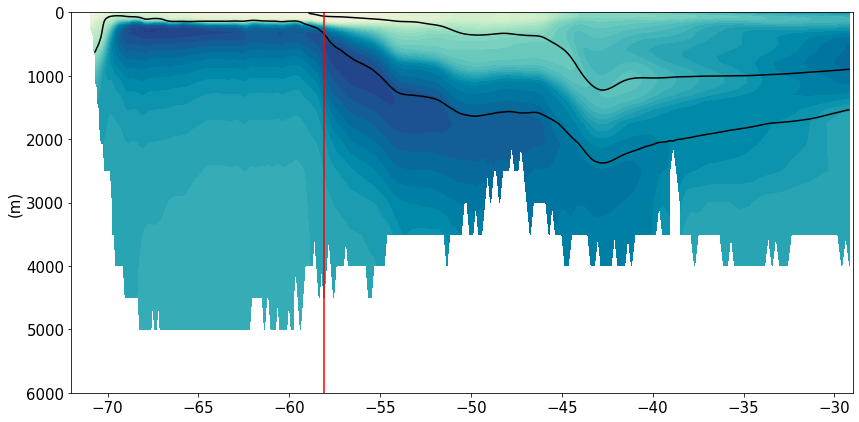

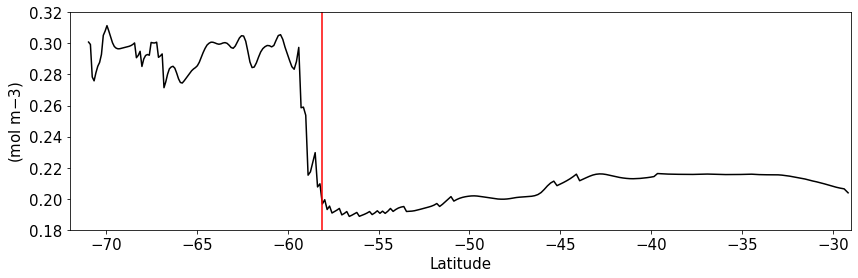

In [31]:
plt.figure(figsize=(14,7))
hcl = sequential_hcl("Blue-Yellow")
cmap = hcl.cmap(100)

a = (transect_O2.where(transect_sigma>27.35).where(transect_sigma<27.75)).min(dim = 'z_l')
bdy = a.where(a<UCDW_O2, drop = True)[0].yh.values

ax = plt.subplot()
lvls = np.arange(0.18,0.35, 0.005)
cf = ax.contourf(transect_O2.yh, transect_O2.z_l, transect_O2, levels = lvls,extend = 'both',cmap = cmap)
lvls = [27.35,27.75]
ax.contour(transect_sigma.yh, transect_sigma.z_l, transect_sigma, levels = lvls,colors = 'k')
ax.plot([bdy,bdy], [0,6000], 'r')
ax.set_xlim((-72,-29))
ax.set_ylim((6000,0))
ax.set_ylabel('(m)')

plt.show()


plt.figure(figsize=(14,4))
ax = plt.subplot()

ax.plot(a.yh, a, 'k')
ax.plot([bdy,bdy], [0.18,0.32], 'r')

ax.set_xlim((-72,-29))
ax.set_ylim((0.18,0.32))
ax.set_ylabel('(mol m${-3}$)')
ax.set_xlabel('Latitude')
plt.show()




### Southern ACC boundary (theta max below 500m = 1.8ºC) edit 1.4

In [18]:
theta_subsurface_max = theta_mean.sel(z_l = slice(500,None)).max(dim = 'z_l')

In [19]:
theta_subsurface_max = theta_subsurface_max.load()

In [20]:
contour1 = (theta_subsurface_max.where(theta_subsurface_max<1.4)*0+1).fillna(0)

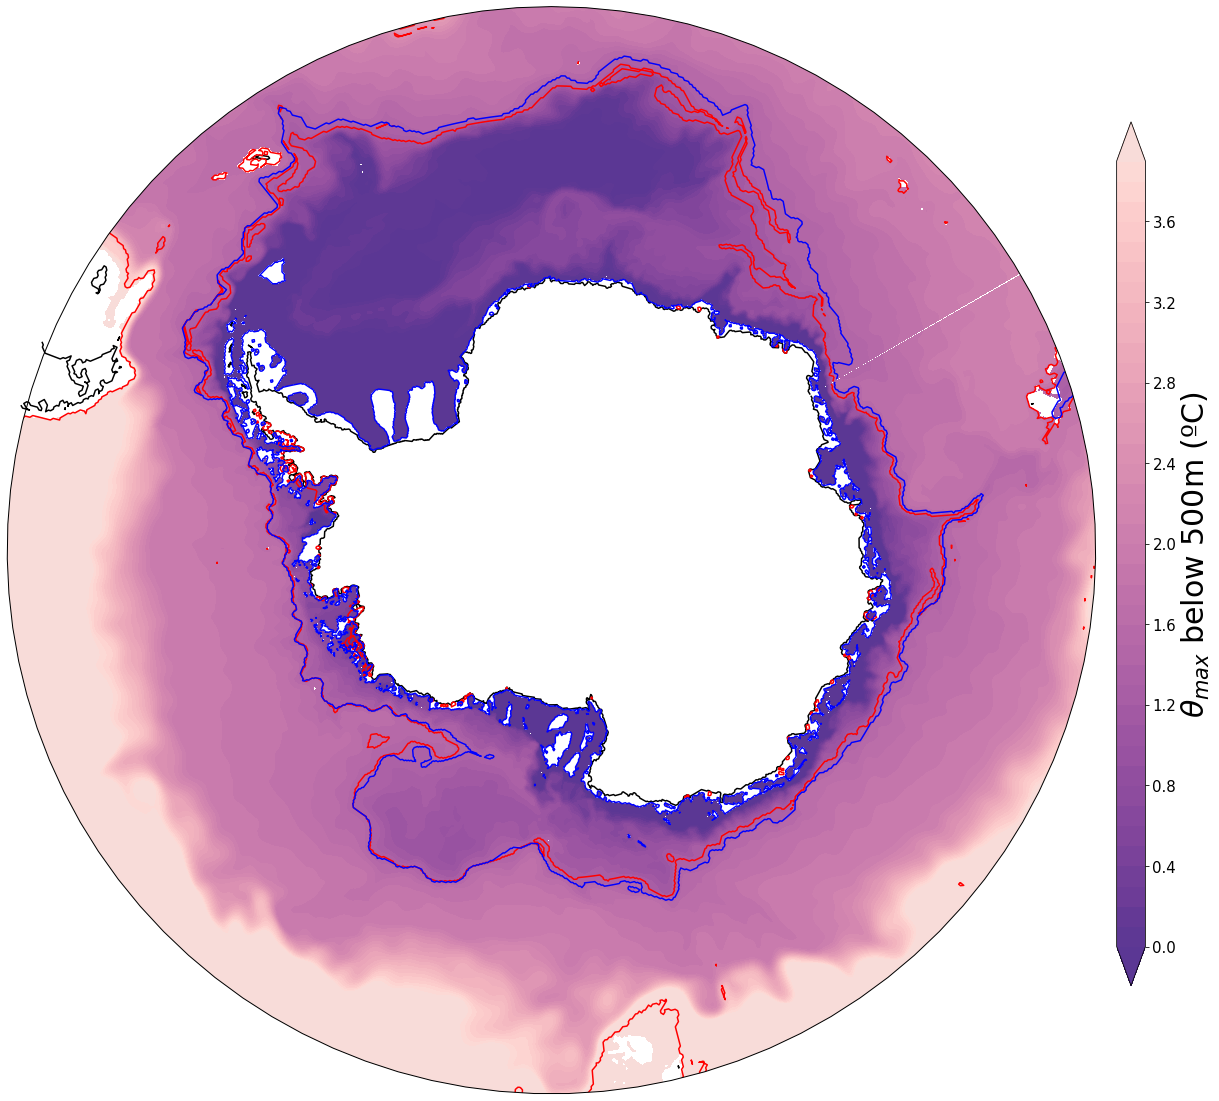

In [21]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,geolon,geolat,lat_north)
hcl = sequential_hcl("Purple-Orange")
cmap = hcl.cmap(100)
lvls = np.arange(0,4,0.1)
cf = ax.contourf(geolon, geolat, theta_subsurface_max, levels = lvls, extend = 'both',cmap = cmap,transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour, levels = [0,1], colors = 'r',transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour1, levels = [0,1], colors = 'b',transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel(r'$\theta_{max}$ below 500m (ºC)', fontsize = 30)

plt.show()

In [32]:
transect_theta = theta_mean.sel(xh = -10, method = 'nearest')
transect_sigma = sigma_mean.sel(xh = -10, method = 'nearest')

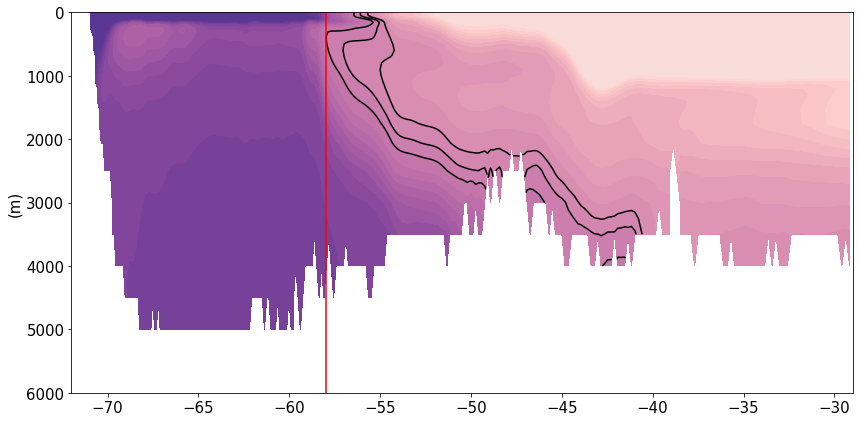

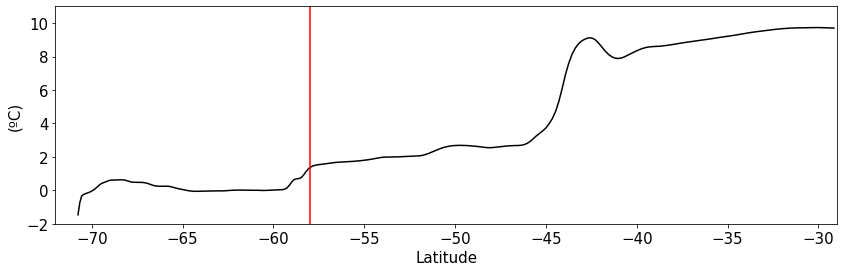

In [35]:
plt.figure(figsize=(14,7))
hcl = sequential_hcl("Purple-Orange")
cmap = hcl.cmap(100)

a =  transect_theta.sel(z_l = slice(500,None)).max(dim = 'z_l')
bdy = a.where(a<1.4, drop = True)[-1].yh.values

ax = plt.subplot()
lvls = np.arange(-1,4, 0.2)
cf = ax.contourf(transect_theta.yh, transect_theta.z_l, transect_theta, levels = lvls,extend = 'both',cmap = cmap)
lvls = [1.4,1.6,1.8]
ax.contour(transect_theta.yh, transect_theta.z_l, transect_theta, levels = lvls,colors = 'k')
ax.plot([bdy,bdy], [0,6000], 'r')
ax.set_xlim((-72,-29))
ax.set_ylim((6000,0))
ax.set_ylabel('(m)')

plt.show()

plt.figure(figsize=(14,4))
ax = plt.subplot()
ax.plot(a.yh, a, 'k')
ax.plot([bdy,bdy], [-2,11], 'r')

ax.set_xlim((-72,-29))
ax.set_ylim((-2,11))
ax.set_ylabel('(ºC)')
ax.set_xlabel('Latitude')
plt.show()




### Southern ACC boundary (theta min above 150m = 0ºC) 

In [24]:
theta_surface_min = theta_mean.sel(z_l = slice(None,150)).min(dim = 'z_l').load()

In [37]:
contour2 = (theta_surface_min.where(theta_surface_min<-1)*0+1).fillna(0)

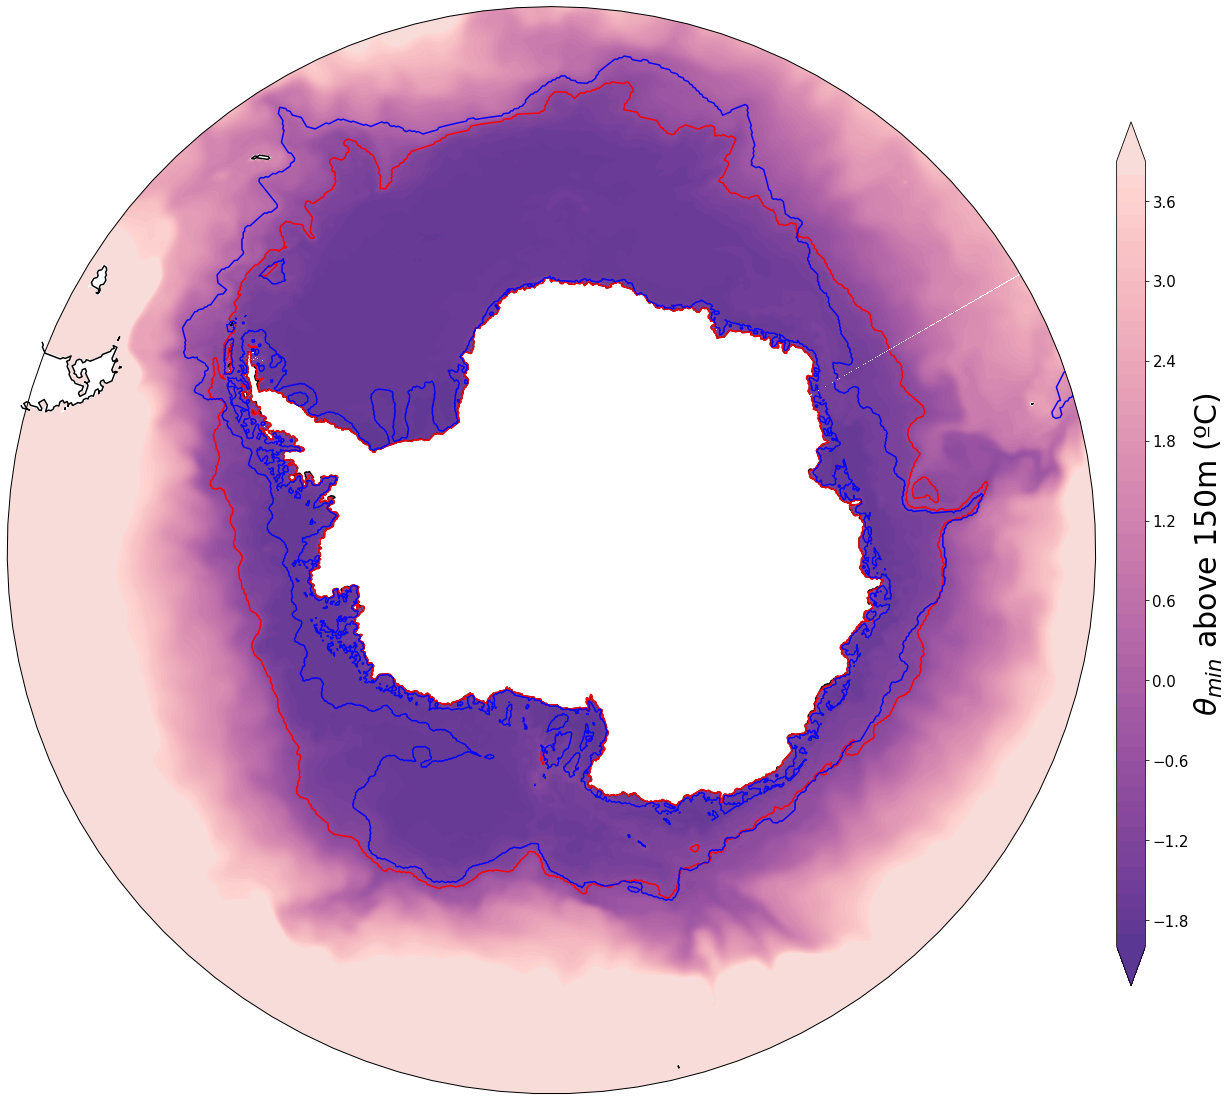

In [38]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,geolon,geolat,lat_north)
hcl = sequential_hcl("Purple-Orange")
cmap = hcl.cmap(100)
lvls = np.arange(-2,4,0.1)
cf = ax.contourf(geolon, geolat, theta_surface_min, levels = lvls, extend = 'both',cmap = cmap,transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour2, levels = [0,1], colors = 'r',transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour1, levels = [0,1], colors = 'b',transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel(r'$\theta_{min}$ above 150m (ºC)', fontsize = 30)

plt.show()

### Southern ACC boundary (S max below 800m = 34.75) 

In [40]:
salt_subsurface_max = salt_mean.sel(z_l = slice(800,None)).max(dim = 'z_l').load()

In [78]:
contour3 = (salt_subsurface_max.where(salt_subsurface_max>34.71)*0+1).fillna(0)

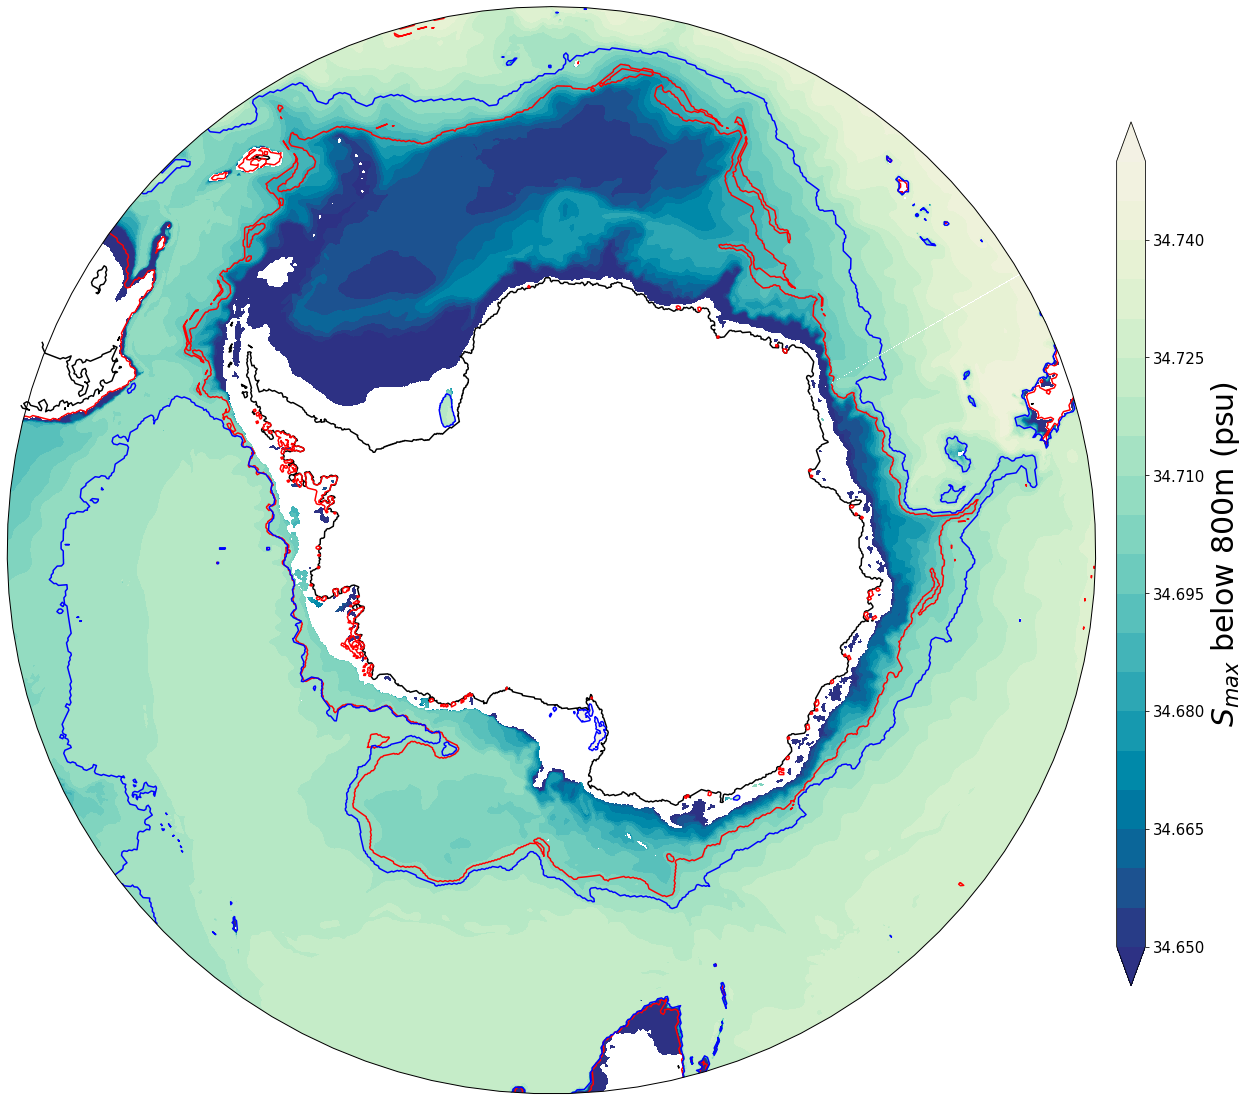

In [79]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,geolon,geolat,lat_north)
hcl = sequential_hcl("Blue-Yellow")
cmap = hcl.cmap(100)
lvls = np.arange(34.65,34.75,0.005)
cf = ax.contourf(geolon, geolat, salt_subsurface_max, levels = lvls, extend = 'both',cmap = cmap,transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour, levels = [0,1], colors = 'r',transform = ccrs.PlateCarree())
ax.contour(geolon, geolat, contour3, levels = [0,1], colors = 'b',transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel(r'$S_{max}$ below 800m (psu)', fontsize = 30)

plt.show()

In [36]:
transect_salt = salt_mean.sel(xh = -10, method = 'nearest')

In [58]:
transect_salt.min()

<xarray.DataArray 'so' ()>
array(33.913563, dtype=float32)
Coordinates:
    xh       float64 -9.922

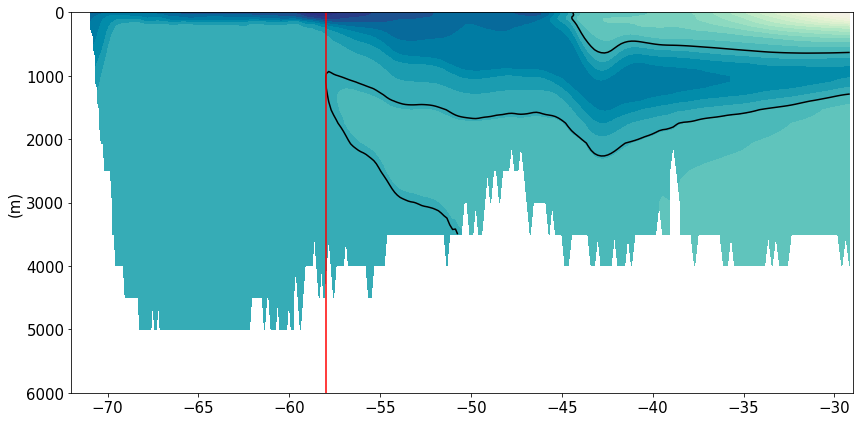

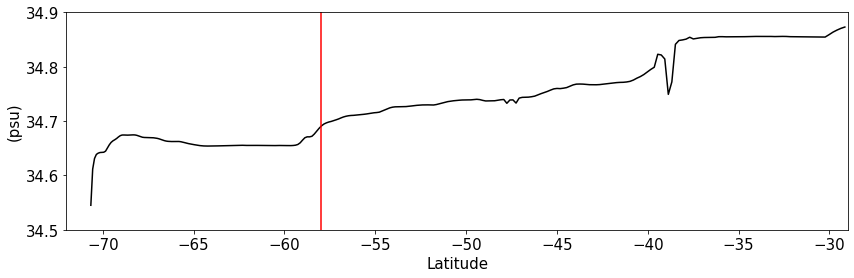

In [40]:
plt.figure(figsize=(14,7))
hcl = sequential_hcl("Blue-Yellow")
cmap = hcl.cmap(100)

a =  transect_salt.sel(z_l = slice(800,None)).max(dim = 'z_l')
# bdy = a.where(a<1.4, drop = True)[-1].yh.values

ax = plt.subplot()
lvls = np.arange(34,36,0.1)
cf = ax.contourf(transect_salt.yh, transect_salt.z_l, transect_salt, levels = lvls,extend = 'both',cmap = cmap)
lvls = [34.69]
ax.contour(transect_salt.yh, transect_salt.z_l, transect_salt, levels = lvls,colors = 'k')
ax.plot([bdy,bdy], [0,6000], 'r')
ax.set_xlim((-72,-29))
ax.set_ylim((6000,0))
ax.set_ylabel('(m)')

plt.show()

plt.figure(figsize=(14,4))
ax = plt.subplot()
ax.plot(a.yh, a, 'k')
ax.plot([bdy,bdy], [34.5,34.9], 'r')

ax.set_xlim((-72,-29))
ax.set_ylim((34.5,34.9))
ax.set_ylabel('(psu)')
ax.set_xlabel('Latitude')


plt.show()


